In [46]:
# Importing libraries

%matplotlib inline

import pandas_datareader as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats
import math
from scipy.stats import norm
import statsmodels.api as sm
import requests
from io import BytesIO
import datetime as dt

#import alpaca_trade_api as tradeapi

In [47]:
# Set Data Date

start = dt.datetime(2000, 1, 1)
end = dt.datetime(2020, 1, 1)

In [187]:

# Download Data

spy_df = pdr.get_data_yahoo(symbols='SPY', start = start, end = end)
vix_df = pdr.get_data_yahoo(symbols='^VIX', start = start, end = end)


In [5]:
# spy_df = spy_df.resample('D').asfreq()
# vix_df = vix_df.resample('D').asfreq()

In [188]:

# Calculate Daily Returns

spy_df['Daily Return'] = (spy_df['Adj Close'] / spy_df['Adj Close'].shift(1)) -1
spy_df.dropna(inplace = True)


In [189]:

# Fit the markov model

mod_spy_df = sm.tsa.MarkovAutoregression(spy_df['Daily Return'], k_regimes = 2, order = 1, switching_ar = True)
res_spy_df = mod_spy_df.fit()


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [106]:

# Get the results

res_spy_df.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:             Daily Return   No. Observations:                 5029
Model:             MarkovAutoregression   Log Likelihood               15305.323
Date:                  Thu, 22 Oct 2020   AIC                         -30596.646
Time:                          10:55:20   BIC                         -30550.986
Sample:                               0   HQIC                        -30580.648
                                 - 5029                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.001     -3.080      0.002      -0.005      -0.001
ar.L1          1.0000      0.078     12.874      0.000       0.848       1.152
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      5.079      0.000       0.001       0.001
ar.L1         -0.1966      0.018    -10.928      0.000      -0.232      -0.161
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0001   2.67e-06     44.791      0.000       0.000       0.000
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.0748      0.033      2.254      0.024       0.010       0.140
p[1->0]        0.1257      0.025      5.019      0.000       0.077       0.175
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

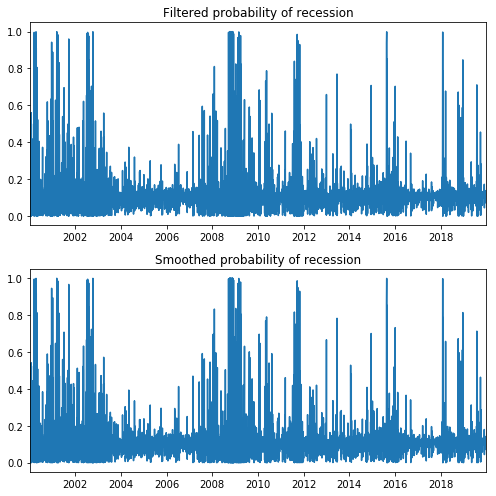

In [52]:

# Plot the probabilties

fig, axes = plt.subplots(2, figsize=(7,7))

ax = axes[0]
ax.plot(res_spy_df.filtered_marginal_probabilities[0])
ax.set_xlim(spy_df.index[4], spy_df.index[-1])
ax.set(title = 'Filtered probability of recession')

ax = axes[1]
ax.plot(res_spy_df.smoothed_marginal_probabilities[0])
ax.set_xlim(spy_df.index[4], spy_df.index[-1])
ax.set(title = 'Smoothed probability of recession')

fig.tight_layout()

In [190]:

# Get the expected duration

print(res_spy_df.expected_durations)


[1.08085332 7.953931  ]


In [201]:

# Adding Bollinger Bands as technical indicator for portfolio rebalancing

spy_df['20 day moving average'] = spy_df['Adj Close'].rolling(window=20).mean()

spy_df['20 day std'] = spy_df['Adj Close'].rolling(window=20).std()

spy_df['Upper Band'] = spy_df['20 day moving average'] + (spy_df['20 day std'] * 1.5)
spy_df['Lower Band'] = spy_df['20 day moving average'] - (spy_df['20 day std'] * 1.5)


In [55]:
# Setup Call & Put functions
def d_1(sigma, T, S, K, r):
    return 1/(sigma*np.sqrt(T))*(np.log(S/K)+(r+(sigma**2)/2)*T)

def d_2(d_1, sigma, T):
    return d_1 - sigma*np.sqrt(T)

def Call(sigma, T, S, K, r):
    d1 = d_1(sigma, T, S, K, r)
    d2 = d_2(d1, sigma, T)
    return norm.cdf(d1)*S-norm.cdf(d2)*K*np.exp(-r*T)

def Put(sigma, T, S, K, r):
    d1 = d_1(sigma, T, S, K, r)
    d2 = d_2(d1, sigma, T)
    return norm.cdf(-d2)*K*np.exp(-r*T)-norm.cdf(-d1)*S


In [1]:
# Object-oriented solution

In [198]:
class option:
    """
    Option class to keep track of invested options, their type (Call/Put), direction (long/short),
    Strike, expiry and volatility regime it has been created in.
    """
    def __init__(self, opt_type, opt_dir, opt_strike, opt_exp, opt_reg):
        self.opt_type = opt_type
        self.opt_dir = opt_dir
        self.opt_strike = opt_strike
        self.opt_exp = opt_exp
        self.opt_reg = opt_reg
        self.state = 'invested'
    
    def option_payout(self, S):
        """
        Calculates an option pay-out depending on direction (long/short),
        option type (call/put), current underlying level (S) and the option's strike (K)
        """
        setattr(self, 'state', 'expired')        
        if self.opt_dir == "s":
            if self.opt_type == "p":
                return -max(0, self.opt_strike-S)
            else:
                return -max(0, S-self.opt_strike)
        else:
            if self.opt_type == "p":
                return max(0, self.opt_strike-S)
            else:
                return max(0, S-self.opt_strike)

    def option_premium(self, vola, cur_date, cur_close):
        """
        Calculates the option's value vor provided volatility, date and current underlying price.
        """
        if self.opt_type == "p":
            prem = Put(vola, timediff(self.opt_exp, cur_date), cur_close, self.opt_strike, 0.005)
        else:
            prem = Call(vola, timediff(self.opt_exp, cur_date), cur_close, self.opt_strike, 0.005)
        if self.opt_dir == "l":
            return -prem
        else:
            return prem
    
    pass

In [94]:
def timediff(date1, date2):
    """
    Helper function to calculate 30/360 yearfrac for calculating
    """
    return (date1.day + date1.month * 30 + date1.year * 360 - (date2.day + date2.month * 30 + date2.year * 360))/360

# Portfolio rebalancing

The following code presents the portfolio rebalancing according to the ruleset. We first initialize a few variables which help us to keep track of the current investment state, portfolio value, and cash-flows.

While we loop through each day of the underlying's data frame (spy_df), we check if the portfolio is currently invested, if an open position expires or if a position has to be rolled to a different position in adherence with our rules.

In [202]:
# Initial investment state = 0 (not invested)
inv_state = 0

# Setting initial portfolio value
pf_value = 0

# Creating list to keep track of portfolio values and cash-flows
pf_value_list = []
pf_cf_list = []

# Create portfolio dataframe with underlyings date index
pf_df = pd.DataFrame(index=spy_df.index)

# Looping through the data and rebalance portfolio

for day in range(len(spy_df)):

    cur_close = spy_df["Adj Close"].iloc[day]
    opt_return = 0
    opt_prem = 0
    current_val = 0
    
    # Set regime state according to smoothed marginal probabilities
    # (0 = low vol | 1 = high vol)
    if spy_df.index[day] >= res_spy_df.smoothed_marginal_probabilities.index[0]:
        reg_state = round(res_spy_df.smoothed_marginal_probabilities.loc[spy_df.index[day]][0])

    # Expiry of options
    if inv_state == 1 and spy_df.index[day] > new_option.opt_exp:
        # Calculating option premium at expiry
        opt_return = new_option.option_payout(spy_df["Adj Close"].iloc[day])
        print("Option expires", spy_df.index[day], "return:", opt_return)

        # Setting investment state to "not invested" = 0
        inv_state = 0

    # High vol and above upper band -> short call
    if cur_close > spy_df["Upper Band"].iloc[day] and reg_state == 1:
        print("State:", reg_state)
        
        if inv_state == 1 and new_option.opt_reg != reg_state:
            #Book out existing option
            opt_prem -= new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)
            print("option booked out on", spy_df.index[day], "close-out premium:", -opt_prem, "option type:", new_option.opt_type, "direction:", new_option.opt_dir)
            
            # Create new option
            new_option = option("c", "s", cur_close, spy_df.index[day] + dt.timedelta(days=30), reg_state)
            opt_prem += new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)
        elif inv_state == 0:
            # Create new option
            new_option = option("c", "s", cur_close, spy_df.index[day] + dt.timedelta(days=30), reg_state)
            opt_prem += new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)

            # Set invested state to 1 = invested
            inv_state = 1

        print("option invested on", spy_df.index[day], "premium:", opt_prem, "option type:", new_option.opt_type, "direction:", new_option.opt_dir)

    # High vol and below lower band -> short put      
    if cur_close > spy_df["Upper Band"].iloc[day] and inv_state == 0 and reg_state == 1:
        print("State:", reg_state)
        
        if inv_state == 1 and new_option.opt_reg != reg_state:
            #Book out existing option
            opt_prem -= new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)
            print("option booked out on", spy_df.index[day], "close-out premium:", -opt_prem, "option type:", new_option.opt_type, "direction:", new_option.opt_dir)
            
            # Create new option
            new_option = option("p", "s", cur_close, spy_df.index[day] + dt.timedelta(days=30), reg_state)
            opt_prem += new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)

        elif inv_state == 0:
            # Create new option
            new_option = option("p", "s", cur_close, spy_df.index[day] + dt.timedelta(days=30), reg_state)
            opt_prem += new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)

            # Set invested state to 1 = invested
            inv_state = 1

        print("option invested on", spy_df.index[day], "premium:", opt_prem, "option type:", new_option.opt_type, "direction:", new_option.opt_dir)

    # Low vol and below lower band -> long call      
    if cur_close < spy_df["Lower Band"].iloc[day] and inv_state == 0 and reg_state == 0:
        print("State:", reg_state)
        
        if inv_state == 1 and new_option.opt_reg != reg_state:
            #Book out existing option
            opt_prem -= new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)
            print("option booked out on", spy_df.index[day], "close-out premium:", -opt_prem, "option type:", new_option.opt_type, "direction:", new_option.opt_dir)
            
            # Create new option
            new_option = option("c", "l", cur_close, spy_df.index[day] + dt.timedelta(days=30), reg_state)
            opt_prem += new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)

        elif inv_state == 0:
            # Create new option
            new_option = option("c", "l", cur_close, spy_df.index[day] + dt.timedelta(days=30), reg_state)
            opt_prem += new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)

            # Set invested state to 1 = invested
            inv_state = 1

        print("option invested on", spy_df.index[day], "premium:", opt_prem, "option type:", new_option.opt_type, "direction:", new_option.opt_dir)

    # Low vol and above upper band -> long put      
    if cur_close > spy_df["Upper Band"].iloc[day] and inv_state == 0 and reg_state == 0:
        print("State:", reg_state)
        
        if inv_state == 1 and new_option.opt_reg != reg_state:
            #Book out existing option
            opt_prem -= new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)
            print("option booked out on", spy_df.index[day], "close-out premium:", -opt_prem, "option type:", new_option.opt_type, "direction:", new_option.opt_dir)
            
            # Create new option
            new_option = option("p", "l", cur_close, spy_df.index[day] + dt.timedelta(days=30), reg_state)
            opt_prem += new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)

        elif inv_state == 0:
            # Create new option
            new_option = option("p", "l", cur_close, spy_df.index[day] + dt.timedelta(days=30), reg_state)
            opt_prem += new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)

            # Set invested state to 1 = invested
            inv_state = 1


        print("option invested on", spy_df.index[day], "premium:", opt_prem, "option type:", new_option.opt_type, "direction:", new_option.opt_dir)        

    if inv_state == 1:
        current_val = -new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)        
        
    # Keeping track of every day's portfolio value and cash-flows
    pf_cf = opt_prem + opt_return 
    pf_value = current_val+ pf_cf + np.sum(pf_cf_list[:-1])
    print("pf value:", pf_value, "on day", spy_df.index[day], "CF:", pf_cf)
    pf_value_list.append(pf_value)
    pf_cf_list.append(pf_cf)
        
print("pf end value:", pf_value)

# Adding each day's portfolio value to the portfolio dataframe
pf_df["Value"] = pf_value_list
pf_df["Daily CF"] = pf_cf_list

pf value: 0.0 on day 2000-01-04 00:00:00 CF: 0
pf value: 0.0 on day 2000-01-05 00:00:00 CF: 0
pf value: 0 on day 2000-01-06 00:00:00 CF: 0
pf value: 0 on day 2000-01-07 00:00:00 CF: 0
pf value: 0 on day 2000-01-10 00:00:00 CF: 0
pf value: 0 on day 2000-01-11 00:00:00 CF: 0
pf value: 0 on day 2000-01-12 00:00:00 CF: 0
pf value: 0 on day 2000-01-13 00:00:00 CF: 0
pf value: 0 on day 2000-01-14 00:00:00 CF: 0
pf value: 0 on day 2000-01-18 00:00:00 CF: 0
pf value: 0 on day 2000-01-19 00:00:00 CF: 0
pf value: 0 on day 2000-01-20 00:00:00 CF: 0
pf value: 0 on day 2000-01-21 00:00:00 CF: 0
pf value: 0 on day 2000-01-24 00:00:00 CF: 0
pf value: 0 on day 2000-01-25 00:00:00 CF: 0
pf value: 0 on day 2000-01-26 00:00:00 CF: 0
pf value: 0 on day 2000-01-27 00:00:00 CF: 0
pf value: 0 on day 2000-01-28 00:00:00 CF: 0
pf value: 0 on day 2000-01-31 00:00:00 CF: 0
pf value: 0 on day 2000-02-01 00:00:00 CF: 0
pf value: 0 on day 2000-02-02 00:00:00 CF: 0
pf value: 0 on day 2000-02-03 00:00:00 CF: 0
pf val

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


 2000-06-23 00:00:00 CF: 4.562347412109375
pf value: 2.8343349196719956 on day 2000-06-26 00:00:00 CF: 0
pf value: 7.396682331781371 on day 2000-06-27 00:00:00 CF: 0
pf value: 7.396682331781371 on day 2000-06-28 00:00:00 CF: 0
State: 0.0
option invested on 2000-06-29 00:00:00 premium: -2.247572667600231 option type: c direction: l
pf value: 7.396682331781371 on day 2000-06-29 00:00:00 CF: -2.247572667600231
pf value: 9.991412479379342 on day 2000-06-30 00:00:00 CF: 0
pf value: 8.500523349046418 on day 2000-07-03 00:00:00 CF: 0
pf value: 7.461452906973612 on day 2000-07-05 00:00:00 CF: 0
pf value: 7.826608369942669 on day 2000-07-06 00:00:00 CF: 0
pf value: 8.677613516677994 on day 2000-07-07 00:00:00 CF: 0
pf value: 8.524898012813068 on day 2000-07-10 00:00:00 CF: 0
pf value: 8.619834581288416 on day 2000-07-11 00:00:00 CF: 0
pf value: 9.076905285106122 on day 2000-07-12 00:00:00 CF: 0
pf value: 9.399669626454369 on day 2000-07-13 00:00:00 CF: 0
pf value: 10.193847326229402 on day 2000

pf value: 15.551561611780315 on day 2001-01-30 00:00:00 CF: 0
pf value: 15.676012357582714 on day 2001-01-31 00:00:00 CF: 0
pf value: 15.391993113900469 on day 2001-02-01 00:00:00 CF: 0
pf value: 16.369763460489885 on day 2001-02-02 00:00:00 CF: 0
pf value: 15.88482744214145 on day 2001-02-05 00:00:00 CF: 0
pf value: 15.956133948212887 on day 2001-02-06 00:00:00 CF: 0
pf value: 16.14329756673493 on day 2001-02-07 00:00:00 CF: 0
pf value: 16.753442531829727 on day 2001-02-08 00:00:00 CF: 0
pf value: 17.374126804594198 on day 2001-02-09 00:00:00 CF: 0
pf value: 16.462015517830793 on day 2001-02-12 00:00:00 CF: 0
pf value: 16.93602434315899 on day 2001-02-13 00:00:00 CF: 0
pf value: 17.00347667624615 on day 2001-02-14 00:00:00 CF: 0
pf value: 16.216109232424927 on day 2001-02-15 00:00:00 CF: 0
pf value: 17.93363573611292 on day 2001-02-16 00:00:00 CF: 0
pf value: 19.232493298938223 on day 2001-02-20 00:00:00 CF: 0
pf value: 21.130360703345204 on day 2001-02-21 00:00:00 CF: 0
pf value: 21.

pf value: 15.16328671568942 on day 2001-08-09 00:00:00 CF: 0
pf value: 15.16328671568942 on day 2001-08-10 00:00:00 CF: 0
pf value: 15.16328671568942 on day 2001-08-13 00:00:00 CF: 0
pf value: 15.16328671568942 on day 2001-08-14 00:00:00 CF: 0
pf value: 15.16328671568942 on day 2001-08-15 00:00:00 CF: 0
pf value: 15.16328671568942 on day 2001-08-16 00:00:00 CF: 0
State: 0.0
option invested on 2001-08-17 00:00:00 premium: -2.1856248649469734 option type: c direction: l
pf value: 15.16328671568942 on day 2001-08-17 00:00:00 CF: -2.1856248649469734
pf value: 17.55337059321241 on day 2001-08-20 00:00:00 CF: 0
pf value: 14.739349165412175 on day 2001-08-21 00:00:00 CF: 0
pf value: 14.945893760096677 on day 2001-08-22 00:00:00 CF: 0
pf value: 14.739649679048402 on day 2001-08-23 00:00:00 CF: 0
pf value: 15.474570242281171 on day 2001-08-24 00:00:00 CF: 0
pf value: 15.112340803644724 on day 2001-08-27 00:00:00 CF: 0
pf value: 14.505980809941601 on day 2001-08-28 00:00:00 CF: 0
pf value: 14.19

pf value: 3.3245279235791223 on day 2002-05-20 00:00:00 CF: 0
pf value: 2.751784348910828 on day 2002-05-21 00:00:00 CF: 0
pf value: 2.8405847055645417 on day 2002-05-22 00:00:00 CF: 0
pf value: 3.4823345471214147 on day 2002-05-23 00:00:00 CF: 0
pf value: 2.616535464075948 on day 2002-05-24 00:00:00 CF: 0
pf value: 2.191380577219423 on day 2002-05-28 00:00:00 CF: 0
pf value: 1.7060045268070745 on day 2002-05-29 00:00:00 CF: 0
pf value: 1.5039468158443121 on day 2002-05-30 00:00:00 CF: 0
pf value: 1.5550329617816452 on day 2002-05-31 00:00:00 CF: 0
pf value: 0.28455577509156527 on day 2002-06-03 00:00:00 CF: 0
pf value: 0.2563117972719695 on day 2002-06-04 00:00:00 CF: 0
pf value: 0.4392795780587697 on day 2002-06-05 00:00:00 CF: 0
pf value: -0.11550950830773488 on day 2002-06-06 00:00:00 CF: 0
Option expires 2002-06-07 00:00:00 return: 0
State: 0.0
option invested on 2002-06-07 00:00:00 premium: -1.9604376921759936 option type: c direction: l
pf value: -0.11550950830773488 on day 2002

pf value: -3.5095267120861706 on day 2003-01-16 00:00:00 CF: 0
pf value: -4.352092440192351 on day 2003-01-17 00:00:00 CF: 0
pf value: -5.287704898530592 on day 2003-01-21 00:00:00 CF: 0
pf value: -5.854822298766166 on day 2003-01-22 00:00:00 CF: 0
pf value: -5.720662426836228 on day 2003-01-23 00:00:00 CF: 0
pf value: -6.6328123845599585 on day 2003-01-24 00:00:00 CF: 0
Option expires 2003-01-27 00:00:00 return: 0
State: 0.0
option invested on 2003-01-27 00:00:00 premium: -2.368654531976219 option type: c direction: l
pf value: -6.922116575434536 on day 2003-01-27 00:00:00 CF: -2.368654531976219
pf value: -4.540987307192182 on day 2003-01-28 00:00:00 CF: 0
pf value: -6.73112163292722 on day 2003-01-29 00:00:00 CF: 0
pf value: -7.534721284390585 on day 2003-01-30 00:00:00 CF: 0
pf value: -6.985379811643682 on day 2003-01-31 00:00:00 CF: 0
pf value: -7.006663035410874 on day 2003-02-03 00:00:00 CF: 0
pf value: -7.2765867117028975 on day 2003-02-04 00:00:00 CF: 0
pf value: -7.49672720403

pf value: -6.710906943931455 on day 2003-09-29 00:00:00 CF: 0
pf value: -6.168508360772911 on day 2003-09-30 00:00:00 CF: 0
pf value: -7.40501633462636 on day 2003-10-01 00:00:00 CF: 0
pf value: -7.640243598140117 on day 2003-10-02 00:00:00 CF: 0
pf value: -8.118849489231707 on day 2003-10-03 00:00:00 CF: 0
pf value: -8.501224596535874 on day 2003-10-06 00:00:00 CF: 0
pf value: -8.681225108517474 on day 2003-10-07 00:00:00 CF: 0
pf value: -8.754304710191299 on day 2003-10-08 00:00:00 CF: 0
Option expires 2003-10-09 00:00:00 return: 0
pf value: -8.754304710191299 on day 2003-10-09 00:00:00 CF: 0
pf value: -8.754304710191299 on day 2003-10-10 00:00:00 CF: 0
pf value: -8.754304710191299 on day 2003-10-13 00:00:00 CF: 0
pf value: -8.754304710191299 on day 2003-10-14 00:00:00 CF: 0
pf value: -8.754304710191299 on day 2003-10-15 00:00:00 CF: 0
pf value: -8.754304710191299 on day 2003-10-16 00:00:00 CF: 0
pf value: -8.754304710191299 on day 2003-10-17 00:00:00 CF: 0
pf value: -8.7543047101912

pf value: -11.52403978208892 on day 2004-04-28 00:00:00 CF: 0
State: 0.0
option invested on 2004-04-29 00:00:00 premium: -1.5526010757565132 option type: c direction: l
pf value: -11.52403978208892 on day 2004-04-29 00:00:00 CF: -1.5526010757565132
pf value: -10.244956089535492 on day 2004-04-30 00:00:00 CF: 0
pf value: -11.509870315665793 on day 2004-05-03 00:00:00 CF: 0
pf value: -11.578675546033473 on day 2004-05-04 00:00:00 CF: 0
pf value: -11.380878180865189 on day 2004-05-05 00:00:00 CF: 0
pf value: -11.689833112560045 on day 2004-05-06 00:00:00 CF: 0
pf value: -12.215671010736521 on day 2004-05-07 00:00:00 CF: 0
pf value: -12.462460521344642 on day 2004-05-10 00:00:00 CF: 0
pf value: -12.366300339792645 on day 2004-05-11 00:00:00 CF: 0
pf value: -12.24779060253918 on day 2004-05-12 00:00:00 CF: 0
pf value: -12.359255688878534 on day 2004-05-13 00:00:00 CF: 0
pf value: -12.407206105483048 on day 2004-05-14 00:00:00 CF: 0
pf value: -12.644677783868307 on day 2004-05-17 00:00:00 CF

pf value: -10.71593370097819 on day 2004-11-04 00:00:00 CF: 0
pf value: -10.192749959140805 on day 2004-11-05 00:00:00 CF: 0
pf value: -10.320332571619737 on day 2004-11-08 00:00:00 CF: 0
pf value: -10.488078927287155 on day 2004-11-09 00:00:00 CF: 0
pf value: -10.424038989723819 on day 2004-11-10 00:00:00 CF: 0
pf value: -9.780559849632418 on day 2004-11-11 00:00:00 CF: 0
pf value: -9.10814975709254 on day 2004-11-12 00:00:00 CF: 0
Option expires 2004-11-15 00:00:00 return: 6.1137237548828125
State: 0.0
option invested on 2004-11-15 00:00:00 premium: -1.3106468486517642 option type: p direction: l
pf value: -8.897913141918629 on day 2004-11-15 00:00:00 CF: 4.803076906231048
pf value: -13.414343241065971 on day 2004-11-16 00:00:00 CF: 0
pf value: -8.904081867216675 on day 2004-11-17 00:00:00 CF: 0
pf value: -9.005497673430085 on day 2004-11-18 00:00:00 CF: 0
pf value: -8.45340639786395 on day 2004-11-19 00:00:00 CF: 0
pf value: -8.806946995592753 on day 2004-11-22 00:00:00 CF: 0
pf val

pf value: -10.859147945386653 on day 2005-04-29 00:00:00 CF: 0
pf value: -10.859147945386653 on day 2005-05-02 00:00:00 CF: 0
pf value: -10.859147945386653 on day 2005-05-03 00:00:00 CF: 0
pf value: -10.859147945386653 on day 2005-05-04 00:00:00 CF: 0
pf value: -10.859147945386653 on day 2005-05-05 00:00:00 CF: 0
pf value: -10.859147945386653 on day 2005-05-06 00:00:00 CF: 0
pf value: -10.859147945386653 on day 2005-05-09 00:00:00 CF: 0
pf value: -10.859147945386653 on day 2005-05-10 00:00:00 CF: 0
pf value: -10.859147945386653 on day 2005-05-11 00:00:00 CF: 0
pf value: -10.859147945386653 on day 2005-05-12 00:00:00 CF: 0
pf value: -10.859147945386653 on day 2005-05-13 00:00:00 CF: 0
pf value: -10.859147945386653 on day 2005-05-16 00:00:00 CF: 0
pf value: -10.859147945386653 on day 2005-05-17 00:00:00 CF: 0
State: 0.0
option invested on 2005-05-18 00:00:00 premium: -1.325381778338624 option type: p direction: l
pf value: -10.859147945386653 on day 2005-05-18 00:00:00 CF: -1.32538177833

pf value: -9.343648851650727 on day 2005-12-06 00:00:00 CF: 0
pf value: -9.3386287197336 on day 2005-12-07 00:00:00 CF: 0
pf value: -9.34513932457869 on day 2005-12-08 00:00:00 CF: 0
pf value: -9.34779963839457 on day 2005-12-09 00:00:00 CF: 0
Option expires 2005-12-12 00:00:00 return: 0
pf value: -9.347806213917025 on day 2005-12-12 00:00:00 CF: 0
pf value: -9.347806213917025 on day 2005-12-13 00:00:00 CF: 0
State: 0.0
option invested on 2005-12-14 00:00:00 premium: -1.1012447711023583 option type: p direction: l
pf value: -9.347806213917025 on day 2005-12-14 00:00:00 CF: -1.1012447711023583
pf value: -8.100224976549725 on day 2005-12-15 00:00:00 CF: 0
pf value: -9.059337806237956 on day 2005-12-16 00:00:00 CF: 0
pf value: -8.759380356489316 on day 2005-12-19 00:00:00 CF: 0
pf value: -8.853783445060785 on day 2005-12-20 00:00:00 CF: 0
pf value: -9.001234974107973 on day 2005-12-21 00:00:00 CF: 0
pf value: -9.3549828736789 on day 2005-12-22 00:00:00 CF: 0
pf value: -9.406605821142797 o

pf value: -12.777676109198204 on day 2006-07-18 00:00:00 CF: 0
pf value: -13.886291727045837 on day 2006-07-19 00:00:00 CF: 0
pf value: -13.427239882997547 on day 2006-07-20 00:00:00 CF: 0
pf value: -12.886330273922816 on day 2006-07-21 00:00:00 CF: 0
pf value: -14.425216087534231 on day 2006-07-24 00:00:00 CF: 0
pf value: -14.713120172934296 on day 2006-07-25 00:00:00 CF: 0
pf value: -14.873842981721985 on day 2006-07-26 00:00:00 CF: 0
pf value: -14.896580361443192 on day 2006-07-27 00:00:00 CF: 0
pf value: -15.463169488570184 on day 2006-07-28 00:00:00 CF: 0
Option expires 2006-07-31 00:00:00 return: 0
pf value: -15.559751928273279 on day 2006-07-31 00:00:00 CF: 0
pf value: -15.559751928273279 on day 2006-08-01 00:00:00 CF: 0
pf value: -15.559751928273279 on day 2006-08-02 00:00:00 CF: 0
pf value: -15.559751928273279 on day 2006-08-03 00:00:00 CF: 0
pf value: -15.559751928273279 on day 2006-08-04 00:00:00 CF: 0
pf value: -15.559751928273279 on day 2006-08-07 00:00:00 CF: 0
pf value: 

pf value: -22.066877222131723 on day 2007-02-26 00:00:00 CF: 0
pf value: -18.41597984300617 on day 2007-02-27 00:00:00 CF: 0
pf value: -19.516391302579706 on day 2007-02-28 00:00:00 CF: 0
pf value: -19.30158823429592 on day 2007-03-01 00:00:00 CF: 0
pf value: -17.979019968235292 on day 2007-03-02 00:00:00 CF: 0
pf value: -17.078576458076157 on day 2007-03-05 00:00:00 CF: 0
pf value: -18.8475131363806 on day 2007-03-06 00:00:00 CF: 0
pf value: -18.77325596871391 on day 2007-03-07 00:00:00 CF: 0
pf value: -19.65104113043546 on day 2007-03-08 00:00:00 CF: 0
pf value: -19.6966265112801 on day 2007-03-09 00:00:00 CF: 0
pf value: -19.880420834299045 on day 2007-03-12 00:00:00 CF: 0
pf value: -17.814184330461956 on day 2007-03-13 00:00:00 CF: 0
pf value: -18.592085646547076 on day 2007-03-14 00:00:00 CF: 0
pf value: -18.73430072654274 on day 2007-03-15 00:00:00 CF: 0
pf value: -18.437437220590127 on day 2007-03-16 00:00:00 CF: 0
Option expires 2007-03-19 00:00:00 return: 3.6714630126953125
pf

pf value: -17.270542844938902 on day 2007-09-20 00:00:00 CF: 0
pf value: -17.653448611971186 on day 2007-09-21 00:00:00 CF: 0
pf value: -17.64117508436398 on day 2007-09-24 00:00:00 CF: 0
pf value: -17.664656020319022 on day 2007-09-25 00:00:00 CF: 0
pf value: -18.120220664376596 on day 2007-09-26 00:00:00 CF: 0
pf value: -18.534173334608745 on day 2007-09-27 00:00:00 CF: 0
pf value: -18.30644091014984 on day 2007-09-28 00:00:00 CF: 0
pf value: -18.97044239809602 on day 2007-10-01 00:00:00 CF: 0
pf value: -18.90758926595631 on day 2007-10-02 00:00:00 CF: 0
pf value: -18.851118772800064 on day 2007-10-03 00:00:00 CF: 0
pf value: -19.001003925011524 on day 2007-10-04 00:00:00 CF: 0
pf value: -19.53403107717757 on day 2007-10-05 00:00:00 CF: 0
pf value: -19.5033737160374 on day 2007-10-08 00:00:00 CF: 0
pf value: -19.795179199116006 on day 2007-10-09 00:00:00 CF: 0
pf value: -19.78703269335638 on day 2007-10-10 00:00:00 CF: 0
pf value: -19.6634135791084 on day 2007-10-11 00:00:00 CF: 0
pf

pf value: -25.122779565995266 on day 2008-04-23 00:00:00 CF: 0
pf value: -25.375739254177333 on day 2008-04-24 00:00:00 CF: 0
pf value: -25.721137057808384 on day 2008-04-25 00:00:00 CF: 0
pf value: -25.91067644076255 on day 2008-04-28 00:00:00 CF: 0
pf value: -25.921220959227202 on day 2008-04-29 00:00:00 CF: 0
pf value: -25.93299123879007 on day 2008-04-30 00:00:00 CF: 0
pf value: -26.01346749609006 on day 2008-05-01 00:00:00 CF: 0
Option expires 2008-05-02 00:00:00 return: 0
State: 0.0
option invested on 2008-05-02 00:00:00 premium: -2.2324569995832064 option type: p direction: l
pf value: -26.01346749609006 on day 2008-05-02 00:00:00 CF: -2.2324569995832064
pf value: -23.54763460251364 on day 2008-05-05 00:00:00 CF: 0
pf value: -26.365373685909972 on day 2008-05-06 00:00:00 CF: 0
pf value: -25.202790195338423 on day 2008-05-07 00:00:00 CF: 0
pf value: -25.110901574440447 on day 2008-05-08 00:00:00 CF: 0
pf value: -25.025733613857355 on day 2008-05-09 00:00:00 CF: 0
pf value: -26.04

pf value: -31.581326239138022 on day 2008-12-16 00:00:00 CF: 0
pf value: -32.28392379739521 on day 2008-12-17 00:00:00 CF: 0
pf value: -33.61615201085255 on day 2008-12-18 00:00:00 CF: 0
pf value: -33.91767178902596 on day 2008-12-19 00:00:00 CF: 0
Option expires 2008-12-22 00:00:00 return: 4.90399169921875
pf value: -34.8091360224244 on day 2008-12-22 00:00:00 CF: 4.90399169921875
pf value: -39.71312772164315 on day 2008-12-23 00:00:00 CF: 0
pf value: -34.8091360224244 on day 2008-12-24 00:00:00 CF: 0
pf value: -34.8091360224244 on day 2008-12-26 00:00:00 CF: 0
pf value: -34.8091360224244 on day 2008-12-29 00:00:00 CF: 0
pf value: -34.8091360224244 on day 2008-12-30 00:00:00 CF: 0
pf value: -34.8091360224244 on day 2008-12-31 00:00:00 CF: 0
State: 1.0
option invested on 2009-01-02 00:00:00 premium: 3.2667046052105064 option type: c direction: s
pf value: -34.8091360224244 on day 2009-01-02 00:00:00 CF: 3.2667046052105064
pf value: -37.847972708631346 on day 2009-01-05 00:00:00 CF: 0
p

pf value: -27.043673878112028 on day 2009-08-28 00:00:00 CF: 0
pf value: -26.72980816847136 on day 2009-08-31 00:00:00 CF: 0
pf value: -25.447165135366948 on day 2009-09-01 00:00:00 CF: 0
pf value: -25.31545591011888 on day 2009-09-02 00:00:00 CF: 0
pf value: -25.918426220391684 on day 2009-09-03 00:00:00 CF: 0
pf value: -26.767524212736344 on day 2009-09-04 00:00:00 CF: 0
pf value: -27.344679106371178 on day 2009-09-08 00:00:00 CF: 0
pf value: -27.77249912203612 on day 2009-09-09 00:00:00 CF: 0
pf value: -28.188636395170445 on day 2009-09-10 00:00:00 CF: 0
pf value: -28.214995562668907 on day 2009-09-11 00:00:00 CF: 0
pf value: -28.532590811999633 on day 2009-09-14 00:00:00 CF: 0
pf value: -28.676938050452286 on day 2009-09-15 00:00:00 CF: 0
pf value: -28.84234205208192 on day 2009-09-16 00:00:00 CF: 0
pf value: -28.861857117276404 on day 2009-09-17 00:00:00 CF: 0
pf value: -28.878772272641697 on day 2009-09-18 00:00:00 CF: 0
Option expires 2009-09-21 00:00:00 return: 0
pf value: -28.

pf value: -38.891981315169694 on day 2010-06-02 00:00:00 CF: 0
pf value: -38.935654291403026 on day 2010-06-03 00:00:00 CF: 0
pf value: -39.633116725618805 on day 2010-06-04 00:00:00 CF: 0
Option expires 2010-06-07 00:00:00 return: 0
pf value: -39.695740057164414 on day 2010-06-07 00:00:00 CF: 0
pf value: -39.695740057164414 on day 2010-06-08 00:00:00 CF: 0
pf value: -39.695740057164414 on day 2010-06-09 00:00:00 CF: 0
pf value: -39.695740057164414 on day 2010-06-10 00:00:00 CF: 0
pf value: -39.695740057164414 on day 2010-06-11 00:00:00 CF: 0
pf value: -39.695740057164414 on day 2010-06-14 00:00:00 CF: 0
State: 0.0
option invested on 2010-06-15 00:00:00 premium: -2.6843966622928974 option type: p direction: l
pf value: -39.695740057164414 on day 2010-06-15 00:00:00 CF: -2.6843966622928974
pf value: -37.03529917661873 on day 2010-06-16 00:00:00 CF: 0
pf value: -39.92330116566387 on day 2010-06-17 00:00:00 CF: 0
pf value: -40.12398369790151 on day 2010-06-18 00:00:00 CF: 0
pf value: -40.

pf value: -37.755659568853964 on day 2011-01-26 00:00:00 CF: 0
pf value: -37.939849629298564 on day 2011-01-27 00:00:00 CF: 0
pf value: -36.812411797535184 on day 2011-01-28 00:00:00 CF: 0
pf value: -37.455744622989165 on day 2011-01-31 00:00:00 CF: 0
pf value: -38.228784431171164 on day 2011-02-01 00:00:00 CF: 0
pf value: -38.2439061907568 on day 2011-02-02 00:00:00 CF: 0
pf value: -38.394150730495284 on day 2011-02-03 00:00:00 CF: 0
pf value: -38.541878454720916 on day 2011-02-04 00:00:00 CF: 0
pf value: -38.73080606459544 on day 2011-02-07 00:00:00 CF: 0
pf value: -38.77286612349519 on day 2011-02-08 00:00:00 CF: 0
pf value: -38.77883450265342 on day 2011-02-09 00:00:00 CF: 0
pf value: -38.782263661857044 on day 2011-02-10 00:00:00 CF: 0
pf value: -38.78234802496401 on day 2011-02-11 00:00:00 CF: 0
Option expires 2011-02-14 00:00:00 return: 0
State: 0.0
option invested on 2011-02-14 00:00:00 premium: -2.0583339184545366 option type: p direction: l
pf value: -38.78234802496401 on day

pf value: -31.694825174243608 on day 2011-09-02 00:00:00 CF: 0
Option expires 2011-09-06 00:00:00 return: 0
pf value: -32.02800438188518 on day 2011-09-06 00:00:00 CF: 0
pf value: -32.02800438188518 on day 2011-09-07 00:00:00 CF: 0
pf value: -32.02800438188518 on day 2011-09-08 00:00:00 CF: 0
pf value: -32.02800438188518 on day 2011-09-09 00:00:00 CF: 0
pf value: -32.02800438188518 on day 2011-09-12 00:00:00 CF: 0
pf value: -32.02800438188518 on day 2011-09-13 00:00:00 CF: 0
pf value: -32.02800438188518 on day 2011-09-14 00:00:00 CF: 0
pf value: -32.02800438188518 on day 2011-09-15 00:00:00 CF: 0
pf value: -32.02800438188518 on day 2011-09-16 00:00:00 CF: 0
pf value: -32.02800438188518 on day 2011-09-19 00:00:00 CF: 0
pf value: -32.02800438188518 on day 2011-09-20 00:00:00 CF: 0
pf value: -32.02800438188518 on day 2011-09-21 00:00:00 CF: 0
pf value: -32.02800438188518 on day 2011-09-22 00:00:00 CF: 0
State: 0.0
option invested on 2011-09-23 00:00:00 premium: -4.519857357488924 option t

pf value: -30.331014247121672 on day 2012-05-03 00:00:00 CF: 0
pf value: -31.428736368453713 on day 2012-05-04 00:00:00 CF: 0
pf value: -31.658717496955504 on day 2012-05-07 00:00:00 CF: 0
pf value: -31.967668307575053 on day 2012-05-08 00:00:00 CF: 0
pf value: -32.2798616439578 on day 2012-05-09 00:00:00 CF: 0
pf value: -32.36783566851962 on day 2012-05-10 00:00:00 CF: 0
pf value: -32.55355285254768 on day 2012-05-11 00:00:00 CF: 0
Option expires 2012-05-14 00:00:00 return: 0
State: 0.0
option invested on 2012-05-14 00:00:00 premium: -2.8246062972618446 option type: c direction: l
pf value: -32.77546903745858 on day 2012-05-14 00:00:00 CF: -2.8246062972618446
pf value: -30.310106187715824 on day 2012-05-15 00:00:00 CF: 0
pf value: -33.34801067737315 on day 2012-05-16 00:00:00 CF: 0
pf value: -33.82074535692066 on day 2012-05-17 00:00:00 CF: 0
pf value: -34.13424491404736 on day 2012-05-18 00:00:00 CF: 0
pf value: -33.94756266896357 on day 2012-05-21 00:00:00 CF: 0
pf value: -33.875063

pf value: -44.78344443218006 on day 2013-01-08 00:00:00 CF: 0
pf value: -44.92229019850298 on day 2013-01-09 00:00:00 CF: 0
pf value: -45.38820391750933 on day 2013-01-10 00:00:00 CF: 0
pf value: -45.32865124641994 on day 2013-01-11 00:00:00 CF: 0
pf value: -45.17122316408437 on day 2013-01-14 00:00:00 CF: 0
pf value: -45.18184821773717 on day 2013-01-15 00:00:00 CF: 0
pf value: -45.11338578178169 on day 2013-01-16 00:00:00 CF: 0
pf value: -45.61413104776598 on day 2013-01-17 00:00:00 CF: 0
pf value: -45.686049274680855 on day 2013-01-18 00:00:00 CF: 0
pf value: -46.0911985753408 on day 2013-01-22 00:00:00 CF: 0
pf value: -46.24125741980146 on day 2013-01-23 00:00:00 CF: 0
pf value: -46.2501070573164 on day 2013-01-24 00:00:00 CF: 0
pf value: -46.90309008008711 on day 2013-01-25 00:00:00 CF: 0
pf value: -46.71282615662486 on day 2013-01-28 00:00:00 CF: 0
pf value: -47.21022239946494 on day 2013-01-29 00:00:00 CF: 0
pf value: -46.70145471858173 on day 2013-01-30 00:00:00 CF: 0
pf value:

pf value: -44.827455639652136 on day 2013-10-11 00:00:00 CF: 0
pf value: -44.827455639652136 on day 2013-10-14 00:00:00 CF: 0
pf value: -44.827455639652136 on day 2013-10-15 00:00:00 CF: 0
State: 0.0
option invested on 2013-10-16 00:00:00 premium: -2.4670089520601834 option type: p direction: l
pf value: -44.827455639652136 on day 2013-10-16 00:00:00 CF: -2.4670089520601834
pf value: -43.062123881729256 on day 2013-10-17 00:00:00 CF: 0
pf value: -46.025310792494494 on day 2013-10-18 00:00:00 CF: 0
pf value: -46.12252780562662 on day 2013-10-21 00:00:00 CF: 0
pf value: -46.40595094867973 on day 2013-10-22 00:00:00 CF: 0
pf value: -46.214163740804345 on day 2013-10-23 00:00:00 CF: 0
pf value: -46.43461362495322 on day 2013-10-24 00:00:00 CF: 0
pf value: -46.66128348142356 on day 2013-10-25 00:00:00 CF: 0
pf value: -46.79785711429544 on day 2013-10-28 00:00:00 CF: 0
pf value: -46.963235944666195 on day 2013-10-29 00:00:00 CF: 0
pf value: -46.85160696476021 on day 2013-10-30 00:00:00 CF: 0

pf value: -44.555046449328096 on day 2014-05-20 00:00:00 CF: 0
pf value: -45.58336651748731 on day 2014-05-21 00:00:00 CF: 0
pf value: -45.82273899909668 on day 2014-05-22 00:00:00 CF: 0
pf value: -46.288816498991046 on day 2014-05-23 00:00:00 CF: 0
pf value: -46.86322130401886 on day 2014-05-27 00:00:00 CF: 0
pf value: -46.851374553720724 on day 2014-05-28 00:00:00 CF: 0
pf value: -47.17532006758456 on day 2014-05-29 00:00:00 CF: 0
pf value: -47.30206247172357 on day 2014-05-30 00:00:00 CF: 0
pf value: -47.41712052075915 on day 2014-06-02 00:00:00 CF: 0
pf value: -47.428249253460294 on day 2014-06-03 00:00:00 CF: 0
pf value: -47.519123894740666 on day 2014-06-04 00:00:00 CF: 0
pf value: -47.67256925673663 on day 2014-06-05 00:00:00 CF: 0
pf value: -47.722042564400795 on day 2014-06-06 00:00:00 CF: 0
pf value: -47.72981481365545 on day 2014-06-09 00:00:00 CF: 0
pf value: -47.72986573166829 on day 2014-06-10 00:00:00 CF: 0
pf value: -47.72986574850837 on day 2014-06-11 00:00:00 CF: 0
Op

pf value: -59.63181944468149 on day 2014-12-26 00:00:00 CF: 0
pf value: -60.01665373803413 on day 2014-12-29 00:00:00 CF: 0
pf value: -59.839295380753974 on day 2014-12-30 00:00:00 CF: 0
pf value: -58.98232726737634 on day 2014-12-31 00:00:00 CF: 0
pf value: -59.207112044297354 on day 2015-01-02 00:00:00 CF: 0
Option expires 2015-01-05 00:00:00 return: 4.49267578125
pf value: -55.89270469566454 on day 2015-01-05 00:00:00 CF: 4.49267578125
pf value: -60.38538047691454 on day 2015-01-06 00:00:00 CF: 0
pf value: -55.89270469566454 on day 2015-01-07 00:00:00 CF: 0
pf value: -55.89270469566454 on day 2015-01-08 00:00:00 CF: 0
pf value: -55.89270469566454 on day 2015-01-09 00:00:00 CF: 0
pf value: -55.89270469566454 on day 2015-01-12 00:00:00 CF: 0
pf value: -55.89270469566454 on day 2015-01-13 00:00:00 CF: 0
pf value: -55.89270469566454 on day 2015-01-14 00:00:00 CF: 0
State: 0.0
option invested on 2015-01-15 00:00:00 premium: -4.541783283245394 option type: c direction: l
pf value: -55.892

Option expires 2015-08-10 00:00:00 return: 5.4464263916015625
pf value: -58.09648708173953 on day 2015-08-10 00:00:00 CF: 5.4464263916015625
pf value: -63.542913473341095 on day 2015-08-11 00:00:00 CF: 0
pf value: -58.09648708173953 on day 2015-08-12 00:00:00 CF: 0
pf value: -58.09648708173953 on day 2015-08-13 00:00:00 CF: 0
pf value: -58.09648708173953 on day 2015-08-14 00:00:00 CF: 0
pf value: -58.09648708173953 on day 2015-08-17 00:00:00 CF: 0
pf value: -58.09648708173953 on day 2015-08-18 00:00:00 CF: 0
pf value: -58.09648708173953 on day 2015-08-19 00:00:00 CF: 0
State: 0.0
option invested on 2015-08-20 00:00:00 premium: -4.021878747183237 option type: c direction: l
pf value: -58.09648708173953 on day 2015-08-20 00:00:00 CF: -4.021878747183237
pf value: -54.76667967812614 on day 2015-08-21 00:00:00 CF: 0
pf value: -59.31863716242358 on day 2015-08-24 00:00:00 CF: 0
pf value: -60.5180491450233 on day 2015-08-25 00:00:00 CF: 0
pf value: -59.86849825768368 on day 2015-08-26 00:00:0

pf value: -63.564062722125115 on day 2016-03-15 00:00:00 CF: 0
pf value: -50.096702051525575 on day 2016-03-16 00:00:00 CF: 0
pf value: -50.74736036874375 on day 2016-03-17 00:00:00 CF: 0
pf value: -51.14099898433719 on day 2016-03-18 00:00:00 CF: 0
pf value: -51.417685516105735 on day 2016-03-21 00:00:00 CF: 0
pf value: -51.376112498315116 on day 2016-03-22 00:00:00 CF: 0
pf value: -50.866204041421064 on day 2016-03-23 00:00:00 CF: 0
pf value: -50.929455078278785 on day 2016-03-24 00:00:00 CF: 0
pf value: -51.16443985710034 on day 2016-03-28 00:00:00 CF: 0
pf value: -51.9608253801753 on day 2016-03-29 00:00:00 CF: 0
pf value: -52.22158057864295 on day 2016-03-30 00:00:00 CF: 0
pf value: -52.14560277345256 on day 2016-03-31 00:00:00 CF: 0
pf value: -52.43457672873831 on day 2016-04-01 00:00:00 CF: 0
pf value: -52.41604069840281 on day 2016-04-04 00:00:00 CF: 0
pf value: -51.99462432654496 on day 2016-04-05 00:00:00 CF: 0
pf value: -52.53823166388656 on day 2016-04-06 00:00:00 CF: 0
pf 

pf value: -42.02171945836087 on day 2016-10-19 00:00:00 CF: 0
pf value: -42.42279700455601 on day 2016-10-20 00:00:00 CF: 0
pf value: -42.51059849402362 on day 2016-10-21 00:00:00 CF: 0
pf value: -42.25192007160869 on day 2016-10-24 00:00:00 CF: 0
pf value: -42.64655274673232 on day 2016-10-25 00:00:00 CF: 0
pf value: -42.81430135991706 on day 2016-10-26 00:00:00 CF: 0
pf value: -42.99405055905182 on day 2016-10-27 00:00:00 CF: 0
pf value: -43.241800484868214 on day 2016-10-28 00:00:00 CF: 0
pf value: -43.406338928019586 on day 2016-10-31 00:00:00 CF: 0
pf value: -43.824568007213706 on day 2016-11-01 00:00:00 CF: 0
pf value: -44.26405467307708 on day 2016-11-02 00:00:00 CF: 0
pf value: -44.352498548668905 on day 2016-11-03 00:00:00 CF: 0
pf value: -44.501188816510975 on day 2016-11-04 00:00:00 CF: 0
pf value: -43.749356043739574 on day 2016-11-07 00:00:00 CF: 0
pf value: -43.43062593110633 on day 2016-11-08 00:00:00 CF: 0
pf value: -42.28209961713275 on day 2016-11-09 00:00:00 CF: 0
pf

pf value: -53.21686450748684 on day 2017-05-31 00:00:00 CF: 0
pf value: -54.14008891797837 on day 2017-06-01 00:00:00 CF: 0
pf value: -54.48710199395695 on day 2017-06-02 00:00:00 CF: 0
pf value: -54.50808199867178 on day 2017-06-05 00:00:00 CF: 0
pf value: -54.22164198172015 on day 2017-06-06 00:00:00 CF: 0
pf value: -54.44563741007722 on day 2017-06-07 00:00:00 CF: 0
pf value: -54.581400934608105 on day 2017-06-08 00:00:00 CF: 0
pf value: -54.42138242205203 on day 2017-06-09 00:00:00 CF: 0
pf value: -54.47943175852382 on day 2017-06-12 00:00:00 CF: 0
pf value: -55.04791877349926 on day 2017-06-13 00:00:00 CF: 0
pf value: -55.00564233092228 on day 2017-06-14 00:00:00 CF: 0
pf value: -54.91501804234658 on day 2017-06-15 00:00:00 CF: 0
pf value: -55.06820780481504 on day 2017-06-16 00:00:00 CF: 0
pf value: -55.59716794847908 on day 2017-06-19 00:00:00 CF: 0
pf value: -55.43322081168782 on day 2017-06-20 00:00:00 CF: 0
pf value: -55.51839244012279 on day 2017-06-21 00:00:00 CF: 0
pf valu

pf value: -61.92164524696417 on day 2018-01-05 00:00:00 CF: 0
pf value: -62.12618491574832 on day 2018-01-08 00:00:00 CF: 0
pf value: -62.21221431474638 on day 2018-01-09 00:00:00 CF: 0
pf value: -62.20582661981472 on day 2018-01-10 00:00:00 CF: 0
pf value: -62.67968258132456 on day 2018-01-11 00:00:00 CF: 0
pf value: -62.93615172454263 on day 2018-01-12 00:00:00 CF: 0
pf value: -62.76833726774774 on day 2018-01-16 00:00:00 CF: 0
pf value: -63.0806407415891 on day 2018-01-17 00:00:00 CF: 0
pf value: -63.0503874893507 on day 2018-01-18 00:00:00 CF: 0
pf value: -63.22216646422539 on day 2018-01-19 00:00:00 CF: 0
pf value: -63.313467045343096 on day 2018-01-22 00:00:00 CF: 0
pf value: -63.32032321637241 on day 2018-01-23 00:00:00 CF: 0
pf value: -63.321268337874784 on day 2018-01-24 00:00:00 CF: 0
pf value: -63.32365880671919 on day 2018-01-25 00:00:00 CF: 0
pf value: -63.32613223636201 on day 2018-01-26 00:00:00 CF: 0
pf value: -63.326135290830386 on day 2018-01-29 00:00:00 CF: 0
pf valu

pf value: -44.31594017600192 on day 2018-11-06 00:00:00 CF: 0
pf value: -39.8515405938153 on day 2018-11-07 00:00:00 CF: 0
pf value: -40.324979305367336 on day 2018-11-08 00:00:00 CF: 0
pf value: -42.7446143016809 on day 2018-11-09 00:00:00 CF: 0
pf value: -46.78150273669716 on day 2018-11-12 00:00:00 CF: 0
pf value: -47.34516553554799 on day 2018-11-13 00:00:00 CF: 0
pf value: -48.6001760331436 on day 2018-11-14 00:00:00 CF: 0
pf value: -46.87422023536523 on day 2018-11-15 00:00:00 CF: 0
pf value: -46.602959750211866 on day 2018-11-16 00:00:00 CF: 0
pf value: -50.361369755773566 on day 2018-11-19 00:00:00 CF: 0
pf value: -53.07737277988731 on day 2018-11-20 00:00:00 CF: 0
pf value: -53.14233824928412 on day 2018-11-21 00:00:00 CF: 0
pf value: -54.41365334290454 on day 2018-11-23 00:00:00 CF: 0
Option expires 2018-11-26 00:00:00 return: 2.087371826171875
pf value: -53.14684103716 on day 2018-11-26 00:00:00 CF: 2.087371826171875
pf value: -55.23421286333188 on day 2018-11-27 00:00:00 CF

pf value: -41.95798201901126 on day 2019-07-16 00:00:00 CF: 0
pf value: -40.82016401737375 on day 2019-07-17 00:00:00 CF: 0
pf value: -41.56195280050586 on day 2019-07-18 00:00:00 CF: 0
pf value: -40.61681916762161 on day 2019-07-19 00:00:00 CF: 0
pf value: -41.54613831855651 on day 2019-07-22 00:00:00 CF: 0
pf value: -42.814072212886025 on day 2019-07-23 00:00:00 CF: 0
pf value: -43.507423271211685 on day 2019-07-24 00:00:00 CF: 0
pf value: -43.013540242752065 on day 2019-07-25 00:00:00 CF: 0
pf value: -43.85717913540325 on day 2019-07-26 00:00:00 CF: 0
pf value: -44.001401684786664 on day 2019-07-29 00:00:00 CF: 0
pf value: -43.84365619271568 on day 2019-07-30 00:00:00 CF: 0
pf value: -42.42073901883774 on day 2019-07-31 00:00:00 CF: 0
pf value: -40.52386632662459 on day 2019-08-01 00:00:00 CF: 0
pf value: -38.86645854046777 on day 2019-08-02 00:00:00 CF: 0
Option expires 2019-08-05 00:00:00 return: 14.296234130859375
pf value: -30.375129112911516 on day 2019-08-05 00:00:00 CF: 14.29

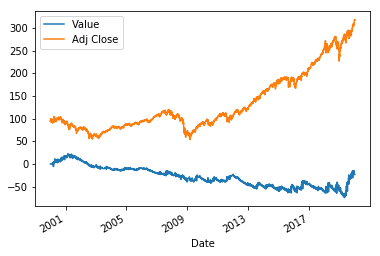

In [206]:
pf_df['Value'].plot()
spy_df['Adj Close'].plot()
plt.legend()

In [207]:
pf_df['Daily Returns'] = (pf_df['Value'] / pf_df['Value'].shift(1)) -1

In [208]:
pf_df.dropna(inplace = True)

In [216]:
# Annual Sharpe Ratio
pf_df['Daily Returns'][1:].mean() / pf_df['Daily Returns'][1:].std() * 252**0.5

-0.0076593576089772995

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 5.000e+00, 3.190e+02,
        4.628e+03, 9.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

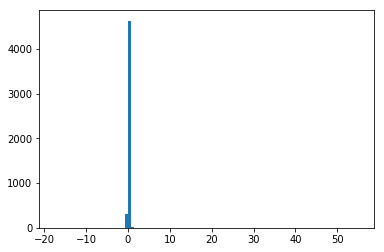

In [214]:
plt.hist(pf_df['Daily Returns'][30:], bins=100)